In [1]:
import numpy as np
import pandas as pd
import nltk
import string
import re
import matplotlib.pyplot as plt
from scipy import stats
from keras.preprocessing import sequence
from keras.layers import  Input, Dense, Flatten, Add,\
    BatchNormalization, Concatenate, Dropout, Activation, Input, Embedding, Conv1D, MaxPooling1D
from keras.optimizers import Adam
from keras.models import Model
import tensorflow as tf
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import keras.backend as K

Using TensorFlow backend.
/home/haoran/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
def flatten(x):
    if isinstance(x, (np.ndarray, list, tuple, pd.Series)):
        lst = []
        for i in x:
            lst += flatten(i)
        return lst
    else:
        return [x]

#### Load Data

In [3]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

In [4]:
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [94]:
output_names = ['toxic','severe_toxic','obscene','threat','insult','identity_hate']

In [95]:
train[output_names].apply(pd.value_counts)

,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,144277,157976,151122,159093,151694,158166
1,15294,1595,8449,478,7877,1405


In [6]:
train['tokens'] = train['comment_text'].apply(lambda x: list(filter(lambda z: len(z), map(lambda y: y.lower(), nltk.word_tokenize(x)))))
test['tokens'] = test['comment_text'].apply(lambda x: list(filter(lambda z: len(z), map(lambda y: y.lower(), nltk.word_tokenize(x)))))

In [7]:
train['tokens'].head()

0    [explanation, why, the, edits, made, under, my...
1    [d'aww, !, he, matches, this, background, colo...
2    [hey, man, ,, i, 'm, really, not, trying, to, ...
3    [``, more, i, ca, n't, make, any, real, sugges...
4    [you, ,, sir, ,, are, my, hero, ., any, chance...
Name: tokens, dtype: object

In [8]:
train['tokLength'] = train['tokens'].apply(lambda x: len(x))

In [9]:
train['tokLength'].describe()

count    159571.000000
mean         80.322201
std         120.769777
min           1.000000
25%          20.000000
50%          43.000000
75%          89.000000
max        4948.000000
Name: tokLength, dtype: float64

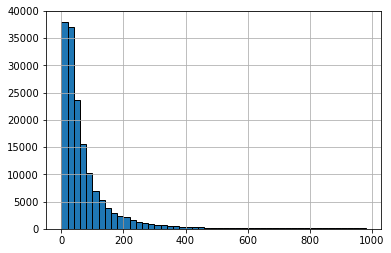

In [10]:
train['tokLength'].hist(bins = range(0, 1000, 20),linewidth = 1, edgecolor = 'black' )
plt.show()
#looks like max_length of 500 should be good

In [11]:
stats.percentileofscore(train['tokLength'].values, 500)

98.256575442906296

In [12]:
max_length = 500

What are the most common words in the texts?

In [13]:
dist = nltk.FreqDist(flatten(train.tokens.values))

In [14]:
print('Number of total tokens in the training set:', dist.N())
print('Number of unique tokens in the training set:', dist.B())

Number of total tokens in the training set: 12817094
Number of unique tokens in the training set: 259285


In [15]:
dist.most_common(n=50)

[('.', 502031),
 ('the', 495401),
 (',', 471812),
 ('to', 296851),
 ("''", 242526),
 ('i', 236559),
 ('of', 224008),
 ('and', 222709),
 ('you', 216674),
 ('a', 214116),
 ('is', 180287),
 ('that', 160512),
 ('``', 155372),
 ('it', 147625),
 ('in', 144392),
 ('!', 105576),
 ('for', 102451),
 ('this', 96943),
 ('not', 96581),
 (')', 90711),
 ('on', 89409),
 ('(', 85085),
 ('be', 83326),
 (':', 82772),
 ('as', 77269),
 ('have', 73939),
 ('are', 73404),
 ('?', 71692),
 ("'s", 66767),
 ('your', 63258),
 ('do', 62602),
 ('with', 59498),
 ('if', 58363),
 ("n't", 57137),
 ('article', 56859),
 ('was', 56537),
 ('or', 52514),
 ('but', 50938),
 ('page', 45656),
 ('my', 45520),
 ('wikipedia', 45418),
 ('an', 44513),
 ('from', 41411),
 ('by', 41040),
 ('at', 39430),
 ('can', 37244),
 ('about', 37043),
 ('me', 37025),
 ('so', 35968),
 ('what', 35291)]

#### Load GloVe

In [16]:
f = open('data/glove.42B.300d.txt', 'r', encoding = 'utf-8')

In [19]:
all_unique_tokens = set(flatten(train.tokens.values)).union(set(flatten(test.tokens.values)))

In [22]:
embeddings = {}
for line in f:
    values = line.split()
    word = values[0]
    # Whole GloVe embeddings doesn't fit in my GPU memory, so only take words which appear in data for now. 
    # Can always swap weights for embedding layer after model training
    if word in all_unique_tokens:
        coefs = np.array(values[1:], dtype = 'float32')
        embeddings[word] = coefs

In [23]:
np.random.seed(10)
embeddings['<UNK>'] = np.random.normal(scale = 0.6,size = embeddings['.'].shape)

What are the most common words not in the vocab?

In [24]:
notInVocab = []
for i in dist.most_common():
    if i[0] not in embeddings.keys() and i[1]>100:
        notInVocab.append((i[0], i[1]))

In [25]:
notInVocab

[('•', 5300),
 ('==', 3145),
 ('~~~~', 1472),
 ('style=', 1303),
 ('·', 1109),
 ('|-', 868),
 ('*', 730),
 ('f5fffa', 713),
 ('..', 683),
 ('width=', 667),
 ('|style=', 635),
 ('====', 627),
 ('yourselfgo', 621),
 ('—preceding', 540),
 ('border:1px', 523),
 ('//en.wikipedia.org/w/index.php', 471),
 ("'image", 420),
 ('philippineslong', 420),
 ('cellpadding=', 372),
 ('pro-assad.hanibal911you', 345),
 ('bitches.fuck', 333),
 ('deneid', 331),
 ('rice=', 330),
 ('three-revert', 328),
 ("'fuck", 325),
 ('\u200e', 321),
 ('pagedelete', 312),
 ('|class=', 308),
 ('notrhbysouthbanof', 308),
 ('→', 307),
 ('mainpagebg', 304),
 ('//', 304),
 ('an/i', 292),
 ('admin-', 289),
 ('criminalwar', 279),
 ('bunksteve', 278),
 ('||', 269),
 ('marcolfuck', 260),
 ('boymamas', 258),
 ('penis/////small', 249),
 ("'the", 244),
 ('edgar181', 236),
 ('//en.wikipedia.org/wiki/wikipedia', 228),
 ('tommy2010', 228),
 ('securityfuck', 227),
 ('edit-warring', 224),
 ('bastered==bastered', 217),
 ('youbollocks', 21

#### Data Preparation

In [33]:
idx2word = {count:i for count, i in enumerate(embeddings.keys())}
word2idx = {idx2word[i]: i for i in idx2word.keys()}

In [34]:
print(word2idx['testing'])
print(word2idx['<UNK>'])
print(idx2word[123])

1674
211860
could


In [35]:
n_factors = 300
vocab_size = len(embeddings)

In [48]:
zero_vector_idx = vocab_size #place blank character last
idx2word[zero_vector_idx] = ''
word2idx[''] = zero_vector_idx

In [59]:
def create_emb():
    emb = np.zeros((vocab_size+1,n_factors), dtype = 'float32')
    for i in range(0, vocab_size):
        word = idx2word[i]
        emb[i,:] = embeddings[word] #each row is a word
    return emb

In [60]:
emb = create_emb()

In [61]:
emb.shape

(211862, 300)

In [62]:
# parse train/test sets
table = str.maketrans("","", string.punctuation)
def toksToInds(listToks):
    ans = []
    for count, i in enumerate(listToks):
        try:
            ans.append(word2idx[i])
        except KeyError:
            temp = i.translate(table)
            if temp and temp in word2idx.keys():
                ans.append(word2idx[temp])
            else:
                ans.append(word2idx['<UNK>'])        
    return np.array(ans)

train['idxInput'] = train['tokens'].apply(toksToInds)
test['idxInput'] = test['tokens'].apply(toksToInds)

In [63]:
train_mat = sequence.pad_sequences(train['idxInput'].values, maxlen = max_length, value = zero_vector_idx)
test_mat = sequence.pad_sequences(test['idxInput'].values, maxlen = max_length, value = zero_vector_idx)

In [64]:
train_mat.shape

(159571, 500)

In [65]:
' '.join([idx2word[i] for i in train_mat[0,:]])

"                                                                                                                                                                                                                                                                                                                                                                                                                                                                   explanation why the edits made under my username hardcore metallica fan were reverted ? they were n't vandalisms , just closure on some gas after i voted at new york dolls fac . and please do n't remove the template from the talk page since i 'm retired <UNK>"

In [66]:
# train test split
indexTrain = np.random.choice(range(train_mat.shape[0]), size = int(0.9*train_mat.shape[0]), replace = False)
indexVal = list(set(range(train_mat.shape[0])) - set(indexTrain))
dataInputTrain = train_mat[indexTrain]
dataInputVal = train_mat[indexVal]
traindf = train.loc[indexTrain]
valdf = train.loc[indexVal]

In [96]:
valdf[output_names].apply(pd.value_counts)

,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,14442,15795,15129,15906,15173,15811
1,1516,163,829,52,785,147


#### Modelling

In [118]:
vec_input = Input(shape = (max_length,))
x = Embedding(vocab_size+1, n_factors, input_length=max_length,weights = [emb], trainable = False)(vec_input)
x = BatchNormalization(axis = -1)(x)
#conv 1
x = Conv1D(16, 7, activation = 'relu')(x)
x = BatchNormalization(axis = -1)(x)
x = MaxPooling1D(pool_size = 2)(x)
x = Dropout(0.2)(x)
#conv 2
x = Conv1D(32, 7, activation = 'relu')(x)
x = BatchNormalization(axis = -1)(x)
x = MaxPooling1D(pool_size = 2)(x)
x = Dropout(0.2)(x)
#conv 3
x = Conv1D(64, 7, activation = 'relu')(x)
x = BatchNormalization(axis = -1)(x)
x = MaxPooling1D(pool_size = 2)(x)
x = Dropout(0.2)(x)
#conv 4
x = Conv1D(64, 7, activation = 'relu')(x)
x = BatchNormalization(axis = -1)(x)
x = MaxPooling1D(pool_size = 2)(x)
x = Dropout(0.2)(x)
#conv 5
x = Conv1D(128, 7, activation = 'relu')(x)
x = BatchNormalization(axis = -1)(x)
x = MaxPooling1D(pool_size = 2)(x)
x = Dropout(0.2)(x)

x = Flatten()(x)
x = Dense(64, activation = 'relu')(x)
x = BatchNormalization(axis = -1)(x)
x = Dropout(0.4)(x)

x = Dense(128, activation = 'relu')(x)
x = BatchNormalization(axis = -1)(x)
x = Dropout(0.4)(x)

In [119]:
# add output layers
outputs = []
for i in output_names:
    intermediate_act = Dense(units = 128, activation = 'relu')(x)
    outputs.append(Dense(units = 1, activation = 'sigmoid', name = i)(intermediate_act))

In [120]:
model = Model(inputs = vec_input, outputs = outputs)

In [121]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 500)          0                                            
__________________________________________________________________________________________________
embedding_7 (Embedding)         (None, 500, 300)     63558600    input_7[0][0]                    
__________________________________________________________________________________________________
batch_normalization_44 (BatchNo (None, 500, 300)     1200        embedding_7[0][0]                
__________________________________________________________________________________________________
conv1d_29 (Conv1D)              (None, 494, 16)      33616       batch_normalization_44[0][0]     
__________________________________________________________________________________________________
batch_norm

In [122]:
model.compile(Adam(1e-5), loss = ['binary_crossentropy']*6, metrics=['accuracy'])

In [123]:
earlyStopping = EarlyStopping(monitor='val_loss', patience=30, verbose=0, mode='min')
mcp_save = ModelCheckpoint('weights/cnn_mdl', save_best_only=True, monitor='val_loss', mode='min')
reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=8, verbose=1, epsilon=1e-4, mode='min')

In [124]:
model.fit(x = dataInputTrain, 
          y = [traindf[i] for i in output_names],
         batch_size = 64, epochs = 2, validation_data = [dataInputVal, [valdf[i] for i in output_names]])

Train on 143613 samples, validate on 15958 samples
Epoch 1/2
143613/143613 [==============================] - 140s 975us/step - loss: 2.5541 - toxic_loss: 0.4970 - severe_toxic_loss: 0.3658 - obscene_loss: 0.4132 - threat_loss: 0.3473 - insult_loss: 0.4095 - identity_hate_loss: 0.5213 - toxic_acc: 0.7953 - severe_toxic_acc: 0.8777 - obscene_acc: 0.8525 - threat_acc: 0.8860 - insult_acc: 0.8566 - identity_hate_acc: 0.7582 - val_loss: 1.6698 - val_toxic_loss: 0.3827 - val_severe_toxic_loss: 0.1813 - val_obscene_loss: 0.3109 - val_threat_loss: 0.1763 - val_insult_loss: 0.3579 - val_identity_hate_loss: 0.2608 - val_toxic_acc: 0.9046 - val_severe_toxic_acc: 0.9898 - val_obscene_acc: 0.9481 - val_threat_acc: 0.9966 - val_insult_acc: 0.9508 - val_identity_hate_acc: 0.9908
Epoch 2/2
143613/143613 [==============================] - 137s 956us/step - loss: 1.0925 - toxic_loss: 0.3377 - severe_toxic_loss: 0.1029 - obscene_loss: 0.2327 - threat_loss: 0.0752 - insult_loss: 0.2227 - identity_hate_lo

In [125]:
model.fit(x = dataInputTrain, 
          y = [traindf[i] for i in output_names],
         batch_size = 64, epochs = 200, validation_data = [dataInputVal, [valdf[i] for i in output_names]],
         callbacks=[earlyStopping, mcp_save, reduce_lr_loss])

Train on 143613 samples, validate on 15958 samples
Epoch 1/200
143613/143613 [==============================] - 140s 978us/step - loss: 0.8995 - toxic_loss: 0.3257 - severe_toxic_loss: 0.0638 - obscene_loss: 0.2150 - threat_loss: 0.0301 - insult_loss: 0.2035 - identity_hate_loss: 0.0614 - toxic_acc: 0.9040 - severe_toxic_acc: 0.9900 - obscene_acc: 0.9469 - threat_acc: 0.9970 - insult_acc: 0.9506 - identity_hate_acc: 0.9912 - val_loss: 0.8904 - val_toxic_loss: 0.3175 - val_severe_toxic_loss: 0.0600 - val_obscene_loss: 0.2182 - val_threat_loss: 0.0294 - val_insult_loss: 0.2085 - val_identity_hate_loss: 0.0568 - val_toxic_acc: 0.9050 - val_severe_toxic_acc: 0.9898 - val_obscene_acc: 0.9481 - val_threat_acc: 0.9967 - val_insult_acc: 0.9508 - val_identity_hate_acc: 0.9908
Epoch 2/200
143613/143613 [==============================] - 138s 959us/step - loss: 0.8697 - toxic_loss: 0.3220 - severe_toxic_loss: 0.0581 - obscene_loss: 0.2120 - threat_loss: 0.0229 - insult_loss: 0.2011 - identity_hat

143613/143613 [==============================] - 137s 952us/step - loss: 0.7526 - toxic_loss: 0.2783 - severe_toxic_loss: 0.0494 - obscene_loss: 0.1847 - threat_loss: 0.0192 - insult_loss: 0.1744 - identity_hate_loss: 0.0466 - toxic_acc: 0.9063 - severe_toxic_acc: 0.9899 - obscene_acc: 0.9469 - threat_acc: 0.9970 - insult_acc: 0.9504 - identity_hate_acc: 0.9912 - val_loss: 0.7193 - val_toxic_loss: 0.2667 - val_severe_toxic_loss: 0.0470 - val_obscene_loss: 0.1723 - val_threat_loss: 0.0196 - val_insult_loss: 0.1666 - val_identity_hate_loss: 0.0471 - val_toxic_acc: 0.9108 - val_severe_toxic_acc: 0.9898 - val_obscene_acc: 0.9499 - val_threat_acc: 0.9967 - val_insult_acc: 0.9518 - val_identity_hate_acc: 0.9908
Epoch 13/200
143613/143613 [==============================] - 137s 951us/step - loss: 0.7408 - toxic_loss: 0.2743 - severe_toxic_loss: 0.0486 - obscene_loss: 0.1815 - threat_loss: 0.0190 - insult_loss: 0.1713 - identity_hate_loss: 0.0461 - toxic_acc: 0.9074 - severe_toxic_acc: 0.9899 

143613/143613 [==============================] - 137s 951us/step - loss: 0.6925 - toxic_loss: 0.2555 - severe_toxic_loss: 0.0459 - obscene_loss: 0.1683 - threat_loss: 0.0185 - insult_loss: 0.1595 - identity_hate_loss: 0.0447 - toxic_acc: 0.9132 - severe_toxic_acc: 0.9899 - obscene_acc: 0.9495 - threat_acc: 0.9970 - insult_acc: 0.9522 - identity_hate_acc: 0.9912 - val_loss: 0.6753 - val_toxic_loss: 0.2495 - val_severe_toxic_loss: 0.0446 - val_obscene_loss: 0.1605 - val_threat_loss: 0.0186 - val_insult_loss: 0.1559 - val_identity_hate_loss: 0.0461 - val_toxic_acc: 0.9145 - val_severe_toxic_acc: 0.9900 - val_obscene_acc: 0.9521 - val_threat_acc: 0.9967 - val_insult_acc: 0.9541 - val_identity_hate_acc: 0.9908
Epoch 24/200
143613/143613 [==============================] - 136s 949us/step - loss: 0.6884 - toxic_loss: 0.2535 - severe_toxic_loss: 0.0459 - obscene_loss: 0.1675 - threat_loss: 0.0184 - insult_loss: 0.1589 - identity_hate_loss: 0.0441 - toxic_acc: 0.9141 - severe_toxic_acc: 0.9899 

143613/143613 [==============================] - 137s 951us/step - loss: 0.6651 - toxic_loss: 0.2452 - severe_toxic_loss: 0.0446 - obscene_loss: 0.1607 - threat_loss: 0.0179 - insult_loss: 0.1531 - identity_hate_loss: 0.0435 - toxic_acc: 0.9172 - severe_toxic_acc: 0.9899 - obscene_acc: 0.9514 - threat_acc: 0.9970 - insult_acc: 0.9536 - identity_hate_acc: 0.9912 - val_loss: 0.6478 - val_toxic_loss: 0.2392 - val_severe_toxic_loss: 0.0439 - val_obscene_loss: 0.1522 - val_threat_loss: 0.0183 - val_insult_loss: 0.1491 - val_identity_hate_loss: 0.0452 - val_toxic_acc: 0.9182 - val_severe_toxic_acc: 0.9900 - val_obscene_acc: 0.9541 - val_threat_acc: 0.9967 - val_insult_acc: 0.9558 - val_identity_hate_acc: 0.9908
Epoch 35/200
143613/143613 [==============================] - 136s 945us/step - loss: 0.6643 - toxic_loss: 0.2444 - severe_toxic_loss: 0.0447 - obscene_loss: 0.1607 - threat_loss: 0.0179 - insult_loss: 0.1532 - identity_hate_loss: 0.0434 - toxic_acc: 0.9175 - severe_toxic_acc: 0.9899 

143613/143613 [==============================] - 136s 947us/step - loss: 0.6513 - toxic_loss: 0.2397 - severe_toxic_loss: 0.0441 - obscene_loss: 0.1572 - threat_loss: 0.0177 - insult_loss: 0.1496 - identity_hate_loss: 0.0430 - toxic_acc: 0.9193 - severe_toxic_acc: 0.9899 - obscene_acc: 0.9523 - threat_acc: 0.9970 - insult_acc: 0.9544 - identity_hate_acc: 0.9912 - val_loss: 0.6372 - val_toxic_loss: 0.2343 - val_severe_toxic_loss: 0.0432 - val_obscene_loss: 0.1495 - val_threat_loss: 0.0182 - val_insult_loss: 0.1469 - val_identity_hate_loss: 0.0451 - val_toxic_acc: 0.9200 - val_severe_toxic_acc: 0.9900 - val_obscene_acc: 0.9550 - val_threat_acc: 0.9967 - val_insult_acc: 0.9563 - val_identity_hate_acc: 0.9908
Epoch 46/200
143613/143613 [==============================] - 136s 946us/step - loss: 0.6502 - toxic_loss: 0.2392 - severe_toxic_loss: 0.0439 - obscene_loss: 0.1567 - threat_loss: 0.0178 - insult_loss: 0.1497 - identity_hate_loss: 0.0429 - toxic_acc: 0.9186 - severe_toxic_acc: 0.9900 

143613/143613 [==============================] - 136s 947us/step - loss: 0.6395 - toxic_loss: 0.2355 - severe_toxic_loss: 0.0433 - obscene_loss: 0.1537 - threat_loss: 0.0178 - insult_loss: 0.1469 - identity_hate_loss: 0.0424 - toxic_acc: 0.9200 - severe_toxic_acc: 0.9899 - obscene_acc: 0.9531 - threat_acc: 0.9970 - insult_acc: 0.9549 - identity_hate_acc: 0.9912 - val_loss: 0.6374 - val_toxic_loss: 0.2337 - val_severe_toxic_loss: 0.0432 - val_obscene_loss: 0.1498 - val_threat_loss: 0.0182 - val_insult_loss: 0.1476 - val_identity_hate_loss: 0.0450 - val_toxic_acc: 0.9193 - val_severe_toxic_acc: 0.9900 - val_obscene_acc: 0.9551 - val_threat_acc: 0.9967 - val_insult_acc: 0.9560 - val_identity_hate_acc: 0.9908
Epoch 57/200
143613/143613 [==============================] - 136s 945us/step - loss: 0.6400 - toxic_loss: 0.2355 - severe_toxic_loss: 0.0437 - obscene_loss: 0.1538 - threat_loss: 0.0176 - insult_loss: 0.1472 - identity_hate_loss: 0.0422 - toxic_acc: 0.9203 - severe_toxic_acc: 0.9899 

143613/143613 [==============================] - 136s 950us/step - loss: 0.6314 - toxic_loss: 0.2320 - severe_toxic_loss: 0.0430 - obscene_loss: 0.1520 - threat_loss: 0.0174 - insult_loss: 0.1449 - identity_hate_loss: 0.0422 - toxic_acc: 0.9217 - severe_toxic_acc: 0.9899 - obscene_acc: 0.9537 - threat_acc: 0.9970 - insult_acc: 0.9553 - identity_hate_acc: 0.9912 - val_loss: 0.6296 - val_toxic_loss: 0.2303 - val_severe_toxic_loss: 0.0428 - val_obscene_loss: 0.1472 - val_threat_loss: 0.0182 - val_insult_loss: 0.1459 - val_identity_hate_loss: 0.0452 - val_toxic_acc: 0.9212 - val_severe_toxic_acc: 0.9900 - val_obscene_acc: 0.9564 - val_threat_acc: 0.9967 - val_insult_acc: 0.9571 - val_identity_hate_acc: 0.9908
Epoch 68/200
143613/143613 [==============================] - 136s 947us/step - loss: 0.6297 - toxic_loss: 0.2313 - severe_toxic_loss: 0.0432 - obscene_loss: 0.1510 - threat_loss: 0.0175 - insult_loss: 0.1450 - identity_hate_loss: 0.0418 - toxic_acc: 0.9216 - severe_toxic_acc: 0.9899 

Epoch 78/200
143613/143613 [==============================] - 136s 946us/step - loss: 0.6225 - toxic_loss: 0.2287 - severe_toxic_loss: 0.0426 - obscene_loss: 0.1494 - threat_loss: 0.0173 - insult_loss: 0.1430 - identity_hate_loss: 0.0415 - toxic_acc: 0.9226 - severe_toxic_acc: 0.9898 - obscene_acc: 0.9543 - threat_acc: 0.9970 - insult_acc: 0.9558 - identity_hate_acc: 0.9912 - val_loss: 0.6322 - val_toxic_loss: 0.2309 - val_severe_toxic_loss: 0.0430 - val_obscene_loss: 0.1482 - val_threat_loss: 0.0182 - val_insult_loss: 0.1465 - val_identity_hate_loss: 0.0453 - val_toxic_acc: 0.9210 - val_severe_toxic_acc: 0.9900 - val_obscene_acc: 0.9559 - val_threat_acc: 0.9967 - val_insult_acc: 0.9571 - val_identity_hate_acc: 0.9908
Epoch 79/200
143613/143613 [==============================] - 136s 946us/step - loss: 0.6238 - toxic_loss: 0.2293 - severe_toxic_loss: 0.0427 - obscene_loss: 0.1495 - threat_loss: 0.0174 - insult_loss: 0.1433 - identity_hate_loss: 0.0416 - toxic_acc: 0.9224 - severe_toxic

Epoch 89/200
143613/143613 [==============================] - 136s 947us/step - loss: 0.6223 - toxic_loss: 0.2281 - severe_toxic_loss: 0.0424 - obscene_loss: 0.1493 - threat_loss: 0.0174 - insult_loss: 0.1431 - identity_hate_loss: 0.0419 - toxic_acc: 0.9226 - severe_toxic_acc: 0.9900 - obscene_acc: 0.9546 - threat_acc: 0.9970 - insult_acc: 0.9560 - identity_hate_acc: 0.9912 - val_loss: 0.6326 - val_toxic_loss: 0.2310 - val_severe_toxic_loss: 0.0431 - val_obscene_loss: 0.1484 - val_threat_loss: 0.0181 - val_insult_loss: 0.1468 - val_identity_hate_loss: 0.0453 - val_toxic_acc: 0.9213 - val_severe_toxic_acc: 0.9900 - val_obscene_acc: 0.9559 - val_threat_acc: 0.9967 - val_insult_acc: 0.9570 - val_identity_hate_acc: 0.9908
Epoch 90/200
143613/143613 [==============================] - 136s 945us/step - loss: 0.6208 - toxic_loss: 0.2279 - severe_toxic_loss: 0.0426 - obscene_loss: 0.1489 - threat_loss: 0.0171 - insult_loss: 0.1424 - identity_hate_loss: 0.0419 - toxic_acc: 0.9222 - severe_toxic

Examining what the model got wrong

In [127]:
pred_val = model.predict(dataInputVal)

In [191]:
for count,i in enumerate(output_names):
    print('---------------' + i + '---------------------')
    dif = (valdf[i] - pred_val[count].flatten()).abs().sort_values(ascending = False)
    most_dif = valdf.loc[dif.index[:2]]
    for count2, j in enumerate(most_dif.iterrows()):
        print('Predicted', pred_val[count].flatten()[valdf[i].index.get_loc(j[0])]
              , 'Actual', j[1][i],
             '\n',
             j[1]['comment_text'])

---------------toxic---------------------
Predicted 0.00101489 Actual 1 
 I guess it is perfectly possible that in 1993 the states did attempt to make all the powers of the councils similar.  Anyway, I think a small section mentioning the differences would be better then nothing. The various legislation can be found at http://www.austlii.edu.au/databases.html with this if you wanted, you could come up with a really detail list of differences.  I'm not doing that just now though (if ever).   (Fuck you!)
Predicted 0.00127391 Actual 1 
 "

Red Hat Ferrick understand something  NEVER ASSUME because you make an ASS-out of-U and-ME O.K.? 

I ALREADY KNEW about the Moluccas/Ternate and Tidore islands , these were actually the fabled ""spice islands"".
They however lasted very short in the Spanish colonial enterprise.

Also we are not discussing the Indochina issue in this section if you didnt see it is above .
Im not going to discuss that issue with you here.  "
---------------severe_toxic---

#### Submission

In [192]:
pred = model.predict(test_mat)

In [197]:
for count,i in enumerate(output_names):
    test[i] = pred[count].flatten()

In [200]:
test[['id', 'toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].to_csv('data/answers/basic_baseline_cnn.csv', index = False)